![image.png](attachment:image.png)

![image.png](attachment:image.png)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/'

In [5]:
directory = '/content/drive/MyDrive/fish/fish'

In [6]:
import os 

In [7]:
# directory = '/content/drive/MyDrive/deep leaning 2nd course /fish'
train_files = []
target_files = []
fish_types = 'Black Sea Sprat'
for file in os.listdir(os.path.join(directory, fish_types)):
    train_files.append(os.path.join(directory, 'Black Sea Sprat', file))
    target_files.append(os.path.join(directory,  'Black Sea Sprat GT', file))

In [8]:
df = pd.DataFrame({'img' : train_files, 'mask' : target_files})
df.head()

,img,mask
0,/content/drive/MyDrive/fish/fish/Black Sea Spr...,/content/drive/MyDrive/fish/fish/Black Sea Spr...
1,/content/drive/MyDrive/fish/fish/Black Sea Spr...,/content/drive/MyDrive/fish/fish/Black Sea Spr...
2,/content/drive/MyDrive/fish/fish/Black Sea Spr...,/content/drive/MyDrive/fish/fish/Black Sea Spr...
3,/content/drive/MyDrive/fish/fish/Black Sea Spr...,/content/drive/MyDrive/fish/fish/Black Sea Spr...
4,/content/drive/MyDrive/fish/fish/Black Sea Spr...,/content/drive/MyDrive/fish/fish/Black Sea Spr...


In [9]:
df1 = pd.DataFrame()

In [10]:
from tqdm import tqdm

In [11]:
df = df[:20]

In [12]:
(df['img'][0])

'/content/drive/MyDrive/fish/fish/Black Sea Sprat/00001.png'

In [13]:
img = []
for ind in tqdm(range(len(df['img']))):
    origImage = cv2.imread(df['img'][ind])
    #origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY, )
    img.append(origImage)
df1['img'] = img

100%|██████████| 20/20 [00:00<00:00, 84.20it/s]


In [14]:
(df['mask'][0])

'/content/drive/MyDrive/fish/fish/Black Sea Sprat GT/00001.png'

In [15]:
mask = []
for ind in tqdm(range(len(df['mask']))):
    origImage = cv2.imread(df['mask'][ind])
    #print(origImage)
    origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY, )
    origImage = (origImage ) 
    mask.append(origImage**2)
df1['mask'] = mask

100%|██████████| 20/20 [00:00<00:00, 163.83it/s]


In [16]:
mask[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [16]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img, mask = gen_df.sample(1).values[0]
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            mask =( mask > 0) **2
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [17]:
mask[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [17]:
for x, y in keras_generator(df1, 16):
    break

In [19]:
x.shape

(16, 256, 256, 3)

In [ ]:
y[0][150]

In [18]:
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation


base_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)


base_out = base_model.output


up = UpSampling2D(32, interpolation='bilinear')(base_out)
conv = Conv2D(1, (1, 1))(up)
conv = Activation('relu')(conv)

model = Model(base_model.input, conv)

In [19]:
from tensorflow import keras

In [20]:
best_w = keras.callbacks.ModelCheckpoint('fcn_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('fcn_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# CHanged PART

In [21]:
df_permutated = df1.sample(frac=1)

train_size = 0.8
train_end = int(len(df_permutated)*train_size)

df_train = df_permutated[:train_end]
df_test = df_permutated[train_end:]

In [22]:
batch_size = 20
model.fit(keras_generator(df_train, batch_size),
              steps_per_epoch=100,
              epochs=5,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(df_test, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/5
100/100 [==============================] - 161s 1s/step - loss: 0.1739 - val_loss: 0.1402
Epoch 2/5
100/100 [==============================] - 147s 1s/step - loss: 0.0460 - val_loss: 0.2230
Epoch 3/5
100/100 [==============================] - 147s 1s/step - loss: 0.0383 - val_loss: 0.2605
Epoch 4/5
100/100 [==============================] - 147s 1s/step - loss: 0.0362 - val_loss: 0.2565
Epoch 5/5
100/100 [==============================] - 147s 1s/step - loss: 0.0347 - val_loss: 0.2081


In [23]:
pred = model.predict(x)#.shape

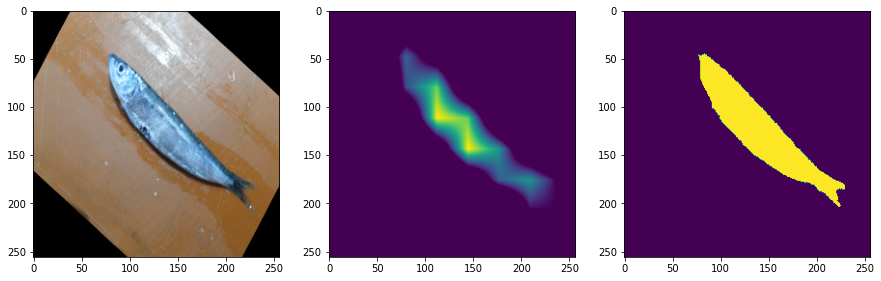

In [25]:
im_id = 1
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(x[im_id])
# axes[1].imshow(pred[im_id, ..., 0] > 0.5)
axes[1].imshow(pred[im_id, ..., 0])
axes[2].imshow(y[im_id, ..., 0])
plt.show()

In [26]:
mask = y[im_id, ..., 0]
pred_mask = pred[im_id, ..., 0] > 0.5

In [27]:
intersection = np.logical_and(mask,pred_mask)
union = np.logical_or(mask,pred_mask)

In [28]:
def IoU(mask, pred_mask):
    # return np.sum(mask*pred_mask)/np.sum(mask+pred_mask)
    # return intersection / union
    return np.sum(intersection) / np.sum(union)

In [29]:
def dice(mask, pred_mask):
    #remeber that for dica you use total number of white pixel in mask + pred_mask (not interseption )
    # return 2*np.sum(mask*pred_mask)/np.sum(mask+pred_mask)
    smooth = 1
    # return (2*intersection + smooth)/ (np.sum(mask) + np.sum(pred_mask) + smooth)
    return (2*np.sum(intersection) + smooth)/ (np.sum(mask) + np.sum(pred_mask) + smooth)


In [30]:
IoU(mask,pred_mask)

0.8606980273141123

In [31]:
dice(mask,pred_mask)

0.9251406670472152